<a href="https://colab.research.google.com/github/gowthami-08/-Linear-Regression/blob/main/Chest_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install necessary packages
!pip install tensorflow keras numpy matplotlib opencv-python seaborn

In [ ]:
# Import required libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Define dataset path (update with your Google Drive location)
dataset_path = "/content/drive/MyDrive/archive/chest_xray"

# Define ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation sets
train_set = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_set = val_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:

import os
import numpy as np
from sklearn.utils import shuffle# Directories for training and testing data
train_dir = '/content/drive/MyDrive/archive/chest_xray/train'
test_dir = '/content/drive/MyDrive/archive/chest_xray/test'
val_dir='/content/drive/MyDrive/archive/chest_xray/val'
# Load and shuffle the train data
train_paths = []
train_labels = []
val_labels=[]
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)
        val_labels.append(label)

train_paths, train_labels, val_labels = shuffle(train_paths, train_labels, val_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
val_labels=[]
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)
        val_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

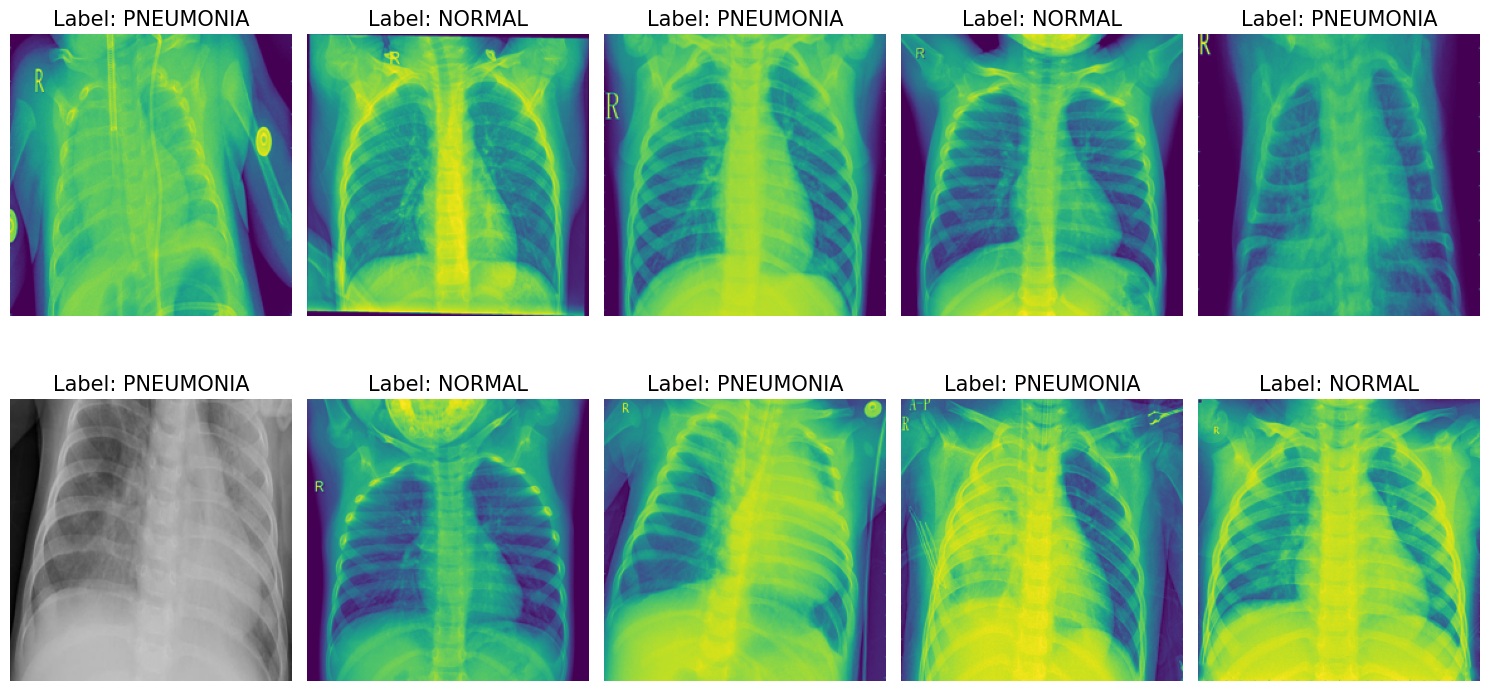

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch(generator function, which loads and processes batches of images instead of the entire dataset at once. This helps save memory.)

In [ ]:
len(os.listdir(train_dir))

2

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
# Import VGG16
from tensorflow.keras.applications import VGG16

In [ ]:
# Image Augmentation function
from keras.utils import load_img, img_to_array  # Import load_img and img_to_array
from PIL import Image, ImageEnhance

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) # Load the image using load_img
        image = img_to_array(image) # Convert the image to a NumPy array using img_to_array
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch(generator function, which loads and processes batches of images instead of the entire dataset at once. This helps save memory.)

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 64
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1354s 17s/step - loss: 0.3002 - sparse_categorical_accuracy: 0.8635
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1323s 16s/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9754
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1321s 16s/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9836
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1315s 16s/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9875
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1320s 16s/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9899
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1318s 16s/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9929
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1296s 16s/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9951
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1294s 16s/step - loss: 0.0179 - sparse_categorical_accuracy: 0.9930
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1302s 16s/step - loss: 0.0139 - sparse_categorical_accuracy: 0.

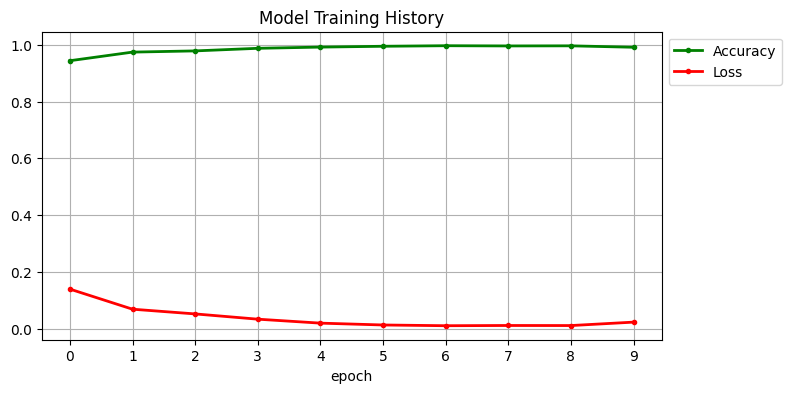

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       390
           1       0.98      0.42      0.59       234

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624



Confusion Matrix:
[[388   2]
 [136  98]]


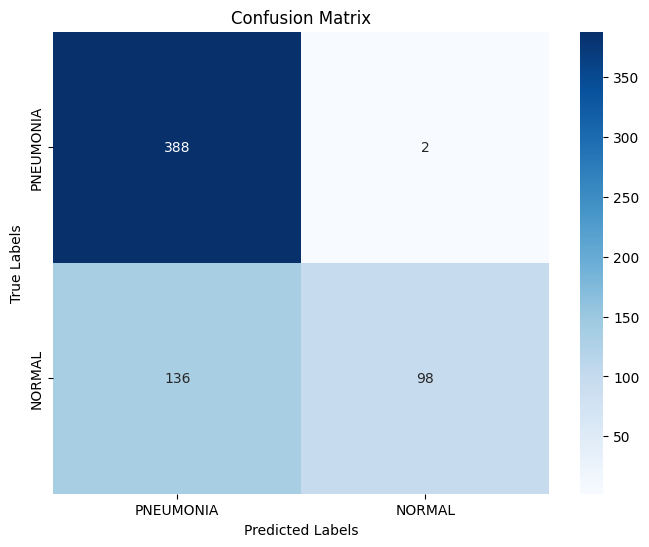

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
final_accuracy = history.history['sparse_categorical_accuracy'][-1]  # Last epoch accuracy
print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")


Final Training Accuracy: 99.15%


In [ ]:
from sklearn.metrics import accuracy_score

test_predictions_labels = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels
test_accuracy = accuracy_score(test_labels_encoded, test_predictions_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 77.88%


In [ ]:
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")


Number of classes: 2


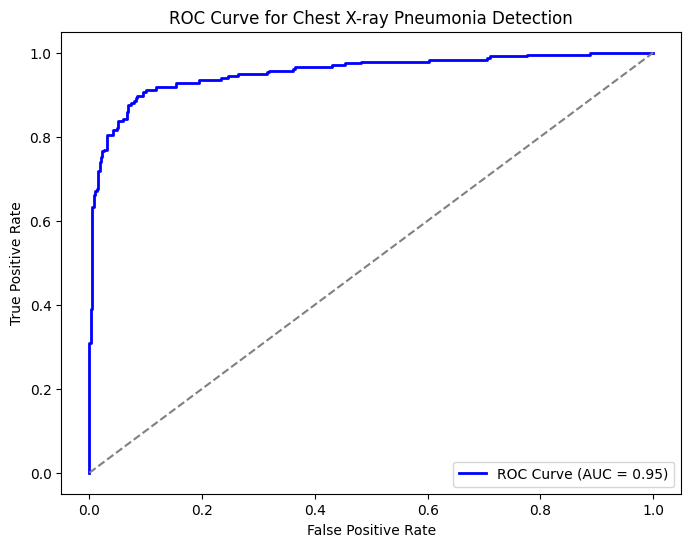

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure test labels are in binary format
test_labels_bin = np.array(test_labels_encoded)  # Must be 0 or 1

# Extract probabilities of the positive class (Pneumonia)
positive_class_prob = test_predictions[:, 1]  # Probability of class 1 (Pneumonia)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(test_labels_bin, positive_class_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Chest X-ray Pneumonia Detection")
plt.legend(loc="lower right")
plt.show()
